## Training RESNET on CIFAR10
#### Using Albumentations for Image Augmentation & LR Finder for finding optimal LR

In [1]:
!rm -rf pytorch_utils
!git clone https://github.com/toniqapps/pytorch_utils.git

Cloning into 'pytorch_utils'...
remote: Enumerating objects: 123, done.
remote: Counting objects: 100% (123/123), done.
remote: Compressing objects: 100% (103/103), done.
remote: Total 123 (delta 71), reused 47 (delta 19), pack-reused 0
Receiving objects: 100% (123/123), 38.25 KiB | 12.75 MiB/s, done.
Resolving deltas: 100% (71/71), done.


In [2]:
!pip install -q -U albumentations
!echo "$(pip freeze | grep albumentations) is successfully installed"

albumentations==0.4.6 is successfully installed


In [3]:
import numpy as np
import pickle
import os
import urllib
import zipfile 
import tarfile
from six.moves import urllib

import matplotlib.pyplot as plt

In [4]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2

### Load CIFAR10 dataset with transforms from Albumentations applied

In [5]:
from pytorch_utils import dataset
train, test = dataset.cifar10_albumentations()

Data has apparently already been downloaded and unpacked.
Loading data: /tmp/cifar-10-data/cifar-10-batches-py/data_batch_1
Loading data: /tmp/cifar-10-data/cifar-10-batches-py/data_batch_2
Loading data: /tmp/cifar-10-data/cifar-10-batches-py/data_batch_3
Loading data: /tmp/cifar-10-data/cifar-10-batches-py/data_batch_4
Loading data: /tmp/cifar-10-data/cifar-10-batches-py/data_batch_5
Loading data: /tmp/cifar-10-data/cifar-10-batches-py/test_batch


In [6]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
trainloader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
testloader = torch.utils.data.DataLoader(test, **dataloader_args)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

CUDA Available? True


### Visualize training dataset to understand the input the model will deal with

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plane   dog  deer  deer truck   cat truck truck   cat   cat


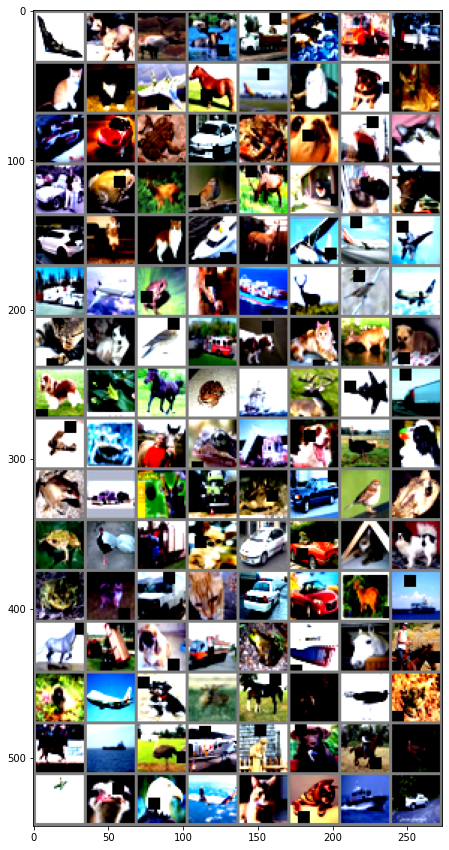

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
plt.figure(figsize = (15,15))
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(10)))

In [8]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

cuda


### Import RESNET model for CIFAR10 dataset

In [9]:
from torchsummary import summary
from pytorch_utils import models

net = models.CIFAR10_RESNET_S8(models.BasicBlock, [2, 2, 2, 2]).to(device)
summary(net, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

### Find optimal LR using LR-Finder

In [10]:
import torch.optim as optim
import torch.nn as nn

from pytorch_utils import lrfinder

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=1e-3, momentum=0.9, weight_decay=5e-4)
lr_finder = lrfinder.LRFinder(net, optimizer, criterion, device=device)
lr_finder.range_test(trainloader, val_loader=testloader, end_lr=100, num_iter=100, step_mode="exp")

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


LR suggestion: steepest gradient
Suggested LR: 1.83E-02


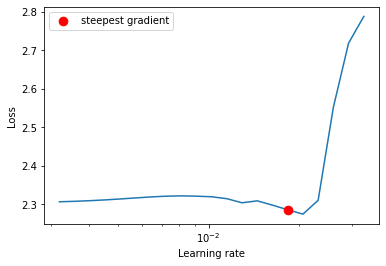

In [11]:
lr_finder.plot()
# restore the model and optimizer to their initial state
lr_finder.reset()

### Train the model with above LR

In [12]:
import torch.optim as optim
from pytorch_utils import train, test
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr= 1.83e-2, momentum=0.9, weight_decay=5e-4)
scheduler = ReduceLROnPlateau(optimizer, 'min')
model_name = 'cifar_10_plot'

train_losses = dict()
train_acc = dict()
test_losses = dict()
test_acc = dict()

train_losses[model_name] = []
train_acc[model_name] = []
test_losses[model_name] = []
test_acc[model_name] = []


EPOCHS = 50
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    tr_loss, tr_acc = train.train(net, device, trainloader, optimizer, criterion, epoch, [], dict())
    te_loss, te_acc = test.test(net, device, testloader, criterion)
    scheduler.step(te_loss[0])
    train_losses[model_name].extend(tr_loss)
    train_acc[model_name].extend(tr_acc)
    test_losses[model_name].extend(te_loss)
    test_acc[model_name].extend(te_acc)

  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.8252542614936829 Batch_id=390 Accuracy=50.65: 100%|██████████| 391/391 [00:29<00:00, 13.40it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0086, Accuracy: 3046/5000 (60.92%)

EPOCH: 1


Loss=0.774168848991394 Batch_id=390 Accuracy=70.81: 100%|██████████| 391/391 [00:28<00:00, 13.50it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0065, Accuracy: 3600/5000 (72.00%)

EPOCH: 2


Loss=0.521818995475769 Batch_id=390 Accuracy=77.75: 100%|██████████| 391/391 [00:29<00:00, 13.46it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0059, Accuracy: 3747/5000 (74.94%)

EPOCH: 3


Loss=0.49224764108657837 Batch_id=390 Accuracy=81.44: 100%|██████████| 391/391 [00:29<00:00, 13.42it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0054, Accuracy: 3884/5000 (77.68%)

EPOCH: 4


Loss=0.634477972984314 Batch_id=390 Accuracy=84.41: 100%|██████████| 391/391 [00:29<00:00, 13.43it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0042, Accuracy: 4102/5000 (82.04%)

EPOCH: 5


Loss=0.25817808508872986 Batch_id=390 Accuracy=86.15: 100%|██████████| 391/391 [00:29<00:00, 13.45it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0044, Accuracy: 4113/5000 (82.26%)

EPOCH: 6


Loss=0.30954107642173767 Batch_id=390 Accuracy=87.97: 100%|██████████| 391/391 [00:29<00:00, 13.40it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0044, Accuracy: 4140/5000 (82.80%)

EPOCH: 7


Loss=0.36725983023643494 Batch_id=390 Accuracy=89.28: 100%|██████████| 391/391 [00:29<00:00, 13.42it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0041, Accuracy: 4187/5000 (83.74%)

EPOCH: 8


Loss=0.14796271920204163 Batch_id=390 Accuracy=90.38: 100%|██████████| 391/391 [00:29<00:00, 13.46it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0036, Accuracy: 4235/5000 (84.70%)

EPOCH: 9


Loss=0.19299058616161346 Batch_id=390 Accuracy=91.68: 100%|██████████| 391/391 [00:28<00:00, 13.49it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0037, Accuracy: 4246/5000 (84.92%)

EPOCH: 10


Loss=0.3595786392688751 Batch_id=390 Accuracy=92.39: 100%|██████████| 391/391 [00:29<00:00, 13.38it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0038, Accuracy: 4281/5000 (85.62%)

EPOCH: 11


Loss=0.23692786693572998 Batch_id=390 Accuracy=92.98: 100%|██████████| 391/391 [00:29<00:00, 13.44it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0041, Accuracy: 4232/5000 (84.64%)

EPOCH: 12


Loss=0.1284881979227066 Batch_id=390 Accuracy=93.99: 100%|██████████| 391/391 [00:29<00:00, 13.44it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0039, Accuracy: 4242/5000 (84.84%)

EPOCH: 13


Loss=0.2019742727279663 Batch_id=390 Accuracy=94.33: 100%|██████████| 391/391 [00:29<00:00, 13.46it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0044, Accuracy: 4193/5000 (83.86%)

EPOCH: 14


Loss=0.10227783024311066 Batch_id=390 Accuracy=94.85: 100%|██████████| 391/391 [00:29<00:00, 13.47it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0039, Accuracy: 4295/5000 (85.90%)

EPOCH: 15


Loss=0.16135218739509583 Batch_id=390 Accuracy=95.29: 100%|██████████| 391/391 [00:29<00:00, 13.40it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0042, Accuracy: 4270/5000 (85.40%)

EPOCH: 16


Loss=0.22745883464813232 Batch_id=390 Accuracy=95.65: 100%|██████████| 391/391 [00:29<00:00, 13.44it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0039, Accuracy: 4304/5000 (86.08%)

EPOCH: 17


Loss=0.12662085890769958 Batch_id=390 Accuracy=95.90: 100%|██████████| 391/391 [00:29<00:00, 13.46it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0044, Accuracy: 4228/5000 (84.56%)

EPOCH: 18


Loss=0.20229390263557434 Batch_id=390 Accuracy=96.11: 100%|██████████| 391/391 [00:29<00:00, 13.44it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0038, Accuracy: 4313/5000 (86.26%)

EPOCH: 19


Loss=0.16446438431739807 Batch_id=390 Accuracy=96.39: 100%|██████████| 391/391 [00:28<00:00, 13.49it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0042, Accuracy: 4220/5000 (84.40%)

EPOCH: 20


Loss=0.05000622197985649 Batch_id=390 Accuracy=98.58: 100%|██████████| 391/391 [00:29<00:00, 13.40it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0027, Accuracy: 4494/5000 (89.88%)

EPOCH: 21


Loss=0.06182105466723442 Batch_id=390 Accuracy=99.24: 100%|██████████| 391/391 [00:29<00:00, 13.42it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0026, Accuracy: 4515/5000 (90.30%)

EPOCH: 22


Loss=0.0467437207698822 Batch_id=390 Accuracy=99.42: 100%|██████████| 391/391 [00:29<00:00, 13.44it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0026, Accuracy: 4518/5000 (90.36%)

EPOCH: 23


Loss=0.01108650304377079 Batch_id=390 Accuracy=99.54: 100%|██████████| 391/391 [00:29<00:00, 13.40it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0026, Accuracy: 4516/5000 (90.32%)

EPOCH: 24


Loss=0.01646348088979721 Batch_id=390 Accuracy=99.61: 100%|██████████| 391/391 [00:29<00:00, 13.48it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0026, Accuracy: 4527/5000 (90.54%)

EPOCH: 25


Loss=0.006109315436333418 Batch_id=390 Accuracy=99.68: 100%|██████████| 391/391 [00:29<00:00, 13.46it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0026, Accuracy: 4536/5000 (90.72%)

EPOCH: 26


Loss=0.029972871765494347 Batch_id=390 Accuracy=99.69: 100%|██████████| 391/391 [00:29<00:00, 13.42it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0026, Accuracy: 4527/5000 (90.54%)

EPOCH: 27


Loss=0.014510728418827057 Batch_id=390 Accuracy=99.73: 100%|██████████| 391/391 [00:29<00:00, 13.34it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0028, Accuracy: 4536/5000 (90.72%)

EPOCH: 28


Loss=0.0327315554022789 Batch_id=390 Accuracy=99.74: 100%|██████████| 391/391 [00:29<00:00, 13.38it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0027, Accuracy: 4543/5000 (90.86%)

EPOCH: 29


Loss=0.021455984562635422 Batch_id=390 Accuracy=99.81: 100%|██████████| 391/391 [00:29<00:00, 13.40it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0028, Accuracy: 4532/5000 (90.64%)

EPOCH: 30


Loss=0.01122740563005209 Batch_id=390 Accuracy=99.80: 100%|██████████| 391/391 [00:29<00:00, 13.37it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0028, Accuracy: 4527/5000 (90.54%)

EPOCH: 31


Loss=0.002941786078736186 Batch_id=390 Accuracy=99.84: 100%|██████████| 391/391 [00:29<00:00, 13.41it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0027, Accuracy: 4528/5000 (90.56%)

EPOCH: 32


Loss=0.005720886401832104 Batch_id=390 Accuracy=99.86: 100%|██████████| 391/391 [00:29<00:00, 13.43it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0026, Accuracy: 4533/5000 (90.66%)

EPOCH: 33


Loss=0.006710793823003769 Batch_id=390 Accuracy=99.89: 100%|██████████| 391/391 [00:29<00:00, 13.40it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0026, Accuracy: 4538/5000 (90.76%)

EPOCH: 34


Loss=0.007059577852487564 Batch_id=390 Accuracy=99.86: 100%|██████████| 391/391 [00:29<00:00, 13.37it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0029, Accuracy: 4539/5000 (90.78%)

EPOCH: 35


Loss=0.010049887001514435 Batch_id=390 Accuracy=99.82: 100%|██████████| 391/391 [00:28<00:00, 13.51it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0027, Accuracy: 4535/5000 (90.70%)

EPOCH: 36


Loss=0.004999724216759205 Batch_id=390 Accuracy=99.84: 100%|██████████| 391/391 [00:29<00:00, 13.40it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0027, Accuracy: 4535/5000 (90.70%)

EPOCH: 37


Loss=0.0039392272010445595 Batch_id=390 Accuracy=99.84: 100%|██████████| 391/391 [00:29<00:00, 13.45it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0028, Accuracy: 4540/5000 (90.80%)

EPOCH: 38


Loss=0.01275239884853363 Batch_id=390 Accuracy=99.84: 100%|██████████| 391/391 [00:29<00:00, 13.43it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0027, Accuracy: 4539/5000 (90.78%)

EPOCH: 39


Loss=0.015468509867787361 Batch_id=390 Accuracy=99.86: 100%|██████████| 391/391 [00:29<00:00, 13.40it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0026, Accuracy: 4538/5000 (90.76%)

EPOCH: 40


Loss=0.004848911892622709 Batch_id=390 Accuracy=99.86: 100%|██████████| 391/391 [00:29<00:00, 13.44it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0027, Accuracy: 4534/5000 (90.68%)

EPOCH: 41


Loss=0.012950737960636616 Batch_id=390 Accuracy=99.86: 100%|██████████| 391/391 [00:29<00:00, 13.37it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0026, Accuracy: 4535/5000 (90.70%)

EPOCH: 42


Loss=0.008539341390132904 Batch_id=390 Accuracy=99.83: 100%|██████████| 391/391 [00:28<00:00, 13.50it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0026, Accuracy: 4536/5000 (90.72%)

EPOCH: 43


Loss=0.007426821626722813 Batch_id=390 Accuracy=99.86: 100%|██████████| 391/391 [00:29<00:00, 13.47it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0026, Accuracy: 4542/5000 (90.84%)

EPOCH: 44


Loss=0.012706222012639046 Batch_id=390 Accuracy=99.85: 100%|██████████| 391/391 [00:29<00:00, 13.40it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0026, Accuracy: 4543/5000 (90.86%)

EPOCH: 45


Loss=0.005478511098772287 Batch_id=390 Accuracy=99.85: 100%|██████████| 391/391 [00:29<00:00, 13.46it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0027, Accuracy: 4540/5000 (90.80%)

EPOCH: 46


Loss=0.004870917648077011 Batch_id=390 Accuracy=99.85: 100%|██████████| 391/391 [00:29<00:00, 13.36it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0027, Accuracy: 4539/5000 (90.78%)

EPOCH: 47


Loss=0.006963884923607111 Batch_id=390 Accuracy=99.86: 100%|██████████| 391/391 [00:29<00:00, 13.38it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0028, Accuracy: 4543/5000 (90.86%)

EPOCH: 48


Loss=0.005391077138483524 Batch_id=390 Accuracy=99.87: 100%|██████████| 391/391 [00:29<00:00, 13.40it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0026, Accuracy: 4531/5000 (90.62%)

EPOCH: 49


Loss=0.037250932306051254 Batch_id=390 Accuracy=99.87: 100%|██████████| 391/391 [00:29<00:00, 13.35it/s]



Test set: Average loss: 0.0028, Accuracy: 4539/5000 (90.78%)



### Training & Test accuracy/loss graphs

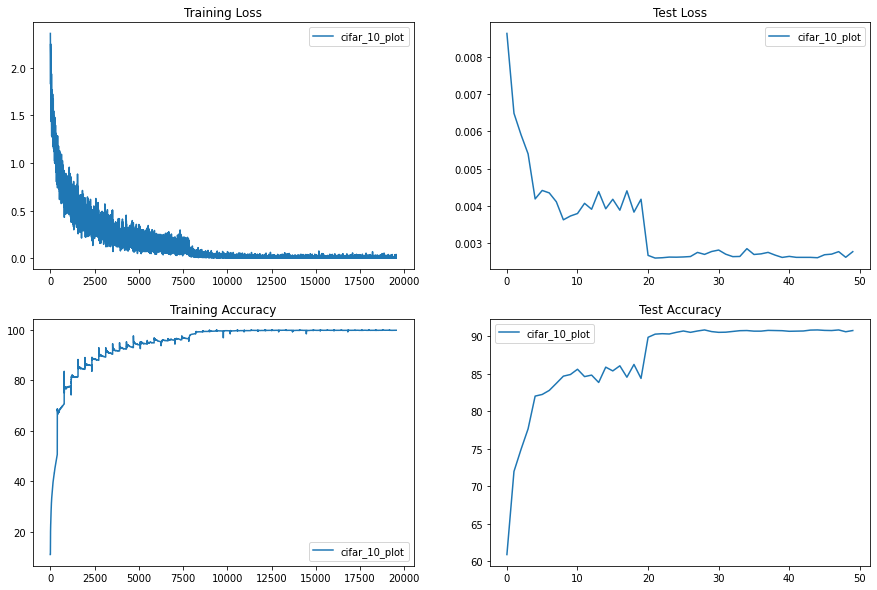

In [13]:
from pytorch_utils import utils

utils.plot_results(train_losses, train_acc, test_losses, test_acc)

### Mis-classified images with gradCAM heatmap

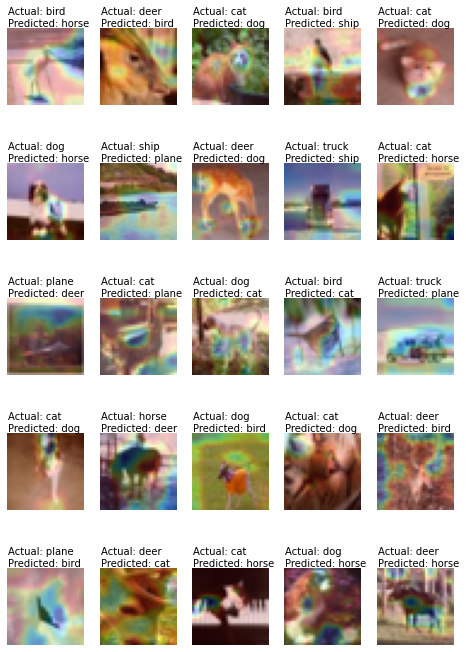

In [14]:
from pytorch_utils import gradcam

# To visualize dataset, perform inverse of normalization
inv_norm = transforms.Normalize((-0.4914/0.2023, -0.4822/0.1994, -0.4465/0.2010), (1/0.2023, 1/0.1994, 1/0.2010))
gradcam.gradcam_misclassified_images_from_model(net, testloader, classes, 25, net.layer3, ["1"], inv_norm, heatmap_opacity=0.25)